# **COMP 499/691 Conversational AI Project 2 - End To End Dialogue System with the Ubuntu Dialogue Corpus**

Submission by Benjamin Lofo Follo (40008156)

In [ ]:
! rm -Rf /content/comp-499-udc
! git clone https://github.com/lamungu/comp-499-udc.git
! mv /content/comp-499-udc/* .

## **Abstract**
   Abstract here. Give an executive summary of your project: goal, methods, results, conclusions. Usually no more than 200 words.

# **1 Introduction**


_Here you have to explain the problem that you are solving. Explain why it is important, and what are the main challenges. Mention previous attempts (add papers as references) to solve it. Mainly focus on the techniques closely related to our approach. Briefly describe your approach and explain why it is promising for solving the addressed problem. Mention the dataset and the main results achieved. In this section, you can add **text** and **figures**._

Recent advancements have proven to be beneficial to the field of conversational AI and Natural Language Processing (NLP). With the latest release of GPT-3 and advent of GPT-4, as well as the prominence of Large Language Models (LLMs) such as Microsoft T5 and Google's BERT, many tasks that have considered to be majorly solved through conventional approaches have been able to breach levels of performance previously unattainable. 

The question remains as to the ability to make use of these models in the every day world, and how it can pierce into the industry. Amongst these place would be the use of intelligent dialogue systems within service departments, where the understanding of context is critical to providing the right aid to customers often requiring time-sensitive intervention from experts. 

In this project, we will be exploring the improvements pre-trained models can bring by matching them next to ones that have been done in the past. We will be using the Ubuntu Dialogue Corpus, our goal will be to assess how well a model can provide context-relevant responses in an end-to-end dialogue system. these approaches while exploring the Ubuntu Dialogue Corpus and training an End-to-End dialogue system.








## **1.1 Task Description**

The project's goal to is to create an end-to-end dialogue system using the Ubuntu Dialogue Corpus. Given the context of a multi-turn dialogue, the model should be able to produce a contextually accurate response back to the user. 

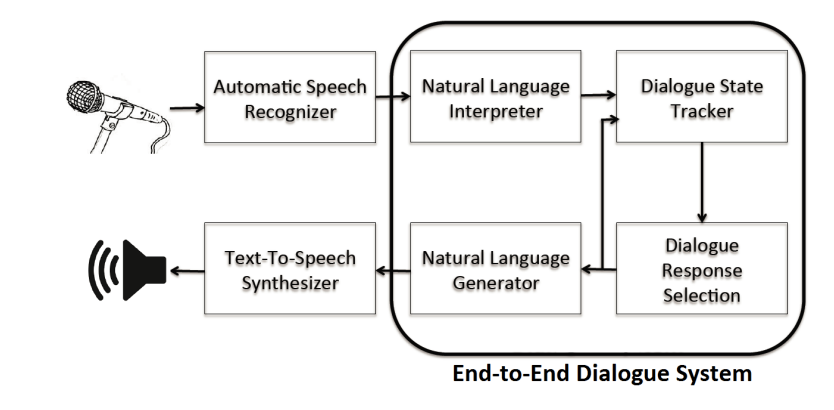

[Figure 1: Lowe , 2017, Training End-to-End Dialogue Systems with the
Ubuntu Dialogue Corpus](https://www.cs.toronto.edu/~lcharlin/papers/ubuntu_dialogue_dd17.pdf)

## **1.2 Dataset**

The dataset is split into training, validation, and test data as you can see by opening `train.csv`, `valid.csv`, and `test.csv`.

The data is formatted differently for the training data than it is for the validation and test data. 

The train data is separated into 3 columns: the context of the conversation (`Context`), the candidate response (`Utterance`), and a flag (`Label`) denoting whether the response is a 'true response' to the context (flag = 1), or a randomly drawn response from elsewhere in the dataset (flag = 0).

The validation and test data contain 11 columns. The row represents a question. Separated into 11 columns: the context (`Context`), the true response to the context (`Ground Truth Utterance`), and 9 false responses (`Distractors`) that were randomly sampled from elsewhere in the dataset. The model gets a question correct if it selects the ground truth utterance from amongst the 10 possible responses.

There are 1 000 000 sentences for training, 19 560 for validation, and 18 920 for testing.

## **1.3 Previous Approaches**

The Ubuntu Dialogue System was initially used in Next Utterance Classification (NUC) tasks. During training, the model is presented a context and was to classify the given utterance based on whether it was relevant to the prior statements. During the validation and test stages, the model is presented ten utterances, one of which is the ground truth, and must determine which of the responses is the correct one. The performance of this model is measured by its Recall@k, with k corresponding the most likely responses to the given context retrieved at test time.

As our task involves the generation of a new response rather than its retrieval, the objective of the task deviates from that of the original paper. Instead, the model will be trained only from the real responses given within the multi-turn dialogues, while validation and test will evaluate the model based on how relevant the generated text is to the context compared to the original text.



## **1.2 Performance Measurement**

To determine whether a model performs well, three metrics will be used to define the performance of a model

# **2 Methodology**

## **2.1 Preparation**

To achieve the goal we have set ourselves, the following resources were required:

- The original Ubuntu Dialogue Corpus files (generated from the [GitHub Repository script](https://github.com/rkadlec/ubuntu-ranking-dataset-creator))
- Preprocessed Training Files (to skip the optional Data Preprocessing step)
- GloVe embeddings Tokenization (to skip the GloVe Embeddings step)
- SentencePiece Tokenizer Model (to skip the SentencePiece step)

## **2.1 Data Cleaning**

Because of the nature of the files, some preprocessing must be done to ensure Speechbrain can properly scan through the stream of text. Hence, some data cleaning has been put in place to ensure the data is digestable by the models. The `spaCy` and `re` packages were used to do basic regex matching and smart replacement of tokens and spans within a text.

| **Before** | yeah yeah, I fixed everything in Ubuntu 12.04 12.04LTS /var/bin/ __eou__ |
|--------|--------------------------------------------------------------------------|
| **After**  | yeah yeah i fixed everything in ubuntu __num__ lts __path__ __eou__      |

The following preprocessing has been done to the text:
- **Removal of special characters**: UDC contains the use of several special characters due to the technical nature of the conversations it holds. Removing them allows for a smaller amount of tokens to analyze in a more coherent fashion
- **Case folding**: allows us to be efficient in reducing the amount of similar words that may be capitalized due to them occuring at the start of sentences.
- **Paths, URLs, and Emails**: Personal identifiable data is highly variable, and creates a high number of low frequency tokens. While the data may not be valuable, replacing them with a placeholder (`__path__`, `__url__` or `__email__`) allows us to maintain the context and stay efficient on our vocabulary usage.

A final removal of special characters was performed at the end to remove the ones required for the detection of important data such as emails, paths and URLs. 

```python
def preprocess(row):
    for key in ['context', 'response']:
        text = row[key]

        # Remove special characters
        text = re.sub('[^\w\s/.:@-]','', text)

        # Define regex pattern to match Bash paths and
        # replace the matches for __path__
        regex = r"(^|\s)(~?(\/[A-Za-z.]+)+)+/?"
        text = re.sub(regex, ' __path__', text)

        # case fold
        text = text.lower()
        
        # Run spacy
        doc = nlp(text)

        # Remove URLs
        tokens = []
        for token in doc:
            if token.is_space:
                continue
            elif token.like_url:
                tokens.append('__url__')
            elif token.like_email:
                tokens.append('__email__')
            elif token.like_num:
                tokens.append('__num__')
            else:
                tokens.append(token.text)
        # Removal of remaining special characters                
        row[key] = re.sub('[^a-z\s_]', '', ' '.join(tokens))
    return row
```

## **2.2 Data Preprocessing**

Following the cleaning of data, some preprocessing was to be done in order to streamline the data to be digested by the function by using the `pandas` package. Across the three datasets, the following steps were taken:

- In the case of the training dataset, we keep the sample whose utterances have a label of `1`. As for the test and validation sets, we only keep the ground truth utterance, and drop the rest of the distractor columns
- We standardized the datasets to provide a context and a response label for each sample.
- Finally, we created an ID for the Speechbrain model to read the dataset properly from the CSV files. An `utt_id` was also provided to calculate the metrics we wish to measure.


```python
for input_file, output_file in [(RAW_TRAIN_FILE, TRAIN_FILE), (RAW_VALID_FILE, VALID_FILE), (RAW_TEST_FILE, TEST_FILE)]:
  print('preprocessing %s...' % input_file)
  stage = input_file.split('.')[0]

  # Fetch the file
  df = pd.read_csv(input_file)

  # Drop and rename needed columns
  if stage == 'train':
    df = df[df.Label == 1]
    df = df.reset_index().drop(TRAIN_DROP_COLUMNS, axis=1)
    df = df.rename(columns={"Context": "context", "Utterance": "response"})
  else:
    df = df.drop(TEST_DROP_COLUMNS, axis=1)
    df = df.rename(columns={"Context": "context", "Ground Truth Utterance": "response"})
  
  # Set an ID column for Speechbrain
  df['ID'] = stage + '_utt' + df.index.map(str)
  df['utt_id'] = df['ID']
  df.set_index('ID', inplace=True)
  
  df = df.apply(preprocess, axis=1)   # Perform the preprocessing script (~2 minutes per set)

  df.to_csv(output_file, index_label='ID', columns = ['utt_id', 'context', 'response'])
  print('Done! saved in %s...' % output_file)
```

## **2.2 Tokenization**

Unlike image and sound processing, natural language processing rely on proper tokenization to properly delineate the data. This essentially requires a proper interpretation of the data on a dimensional field such that semantics can be quantified between words and sentences. Many approaches have been developed over the years to visualize those representations. In this project, we will be exploring two approaches: GloVe and SentencePiece.

### **2.2.1 GloVe Embeddings**

The first initial approach was to make use of  [Global Vectors for Word Representations (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014)](https://nlp.stanford.edu/pubs/glove.pdf), an unsupervised learning algorithm for obtaining vector representations. The representations are retrieved by compiling statistics of word to word co-occurrences within a corpus. Multiple pre-trained models have been built based on an number of data sources such as Wikipedia, Common Crawl and Twitter, with several sets ranging between six and 840 billion tokens, and vocabulary lengths from four hundred thousand upwards to 2.2 million unique words.

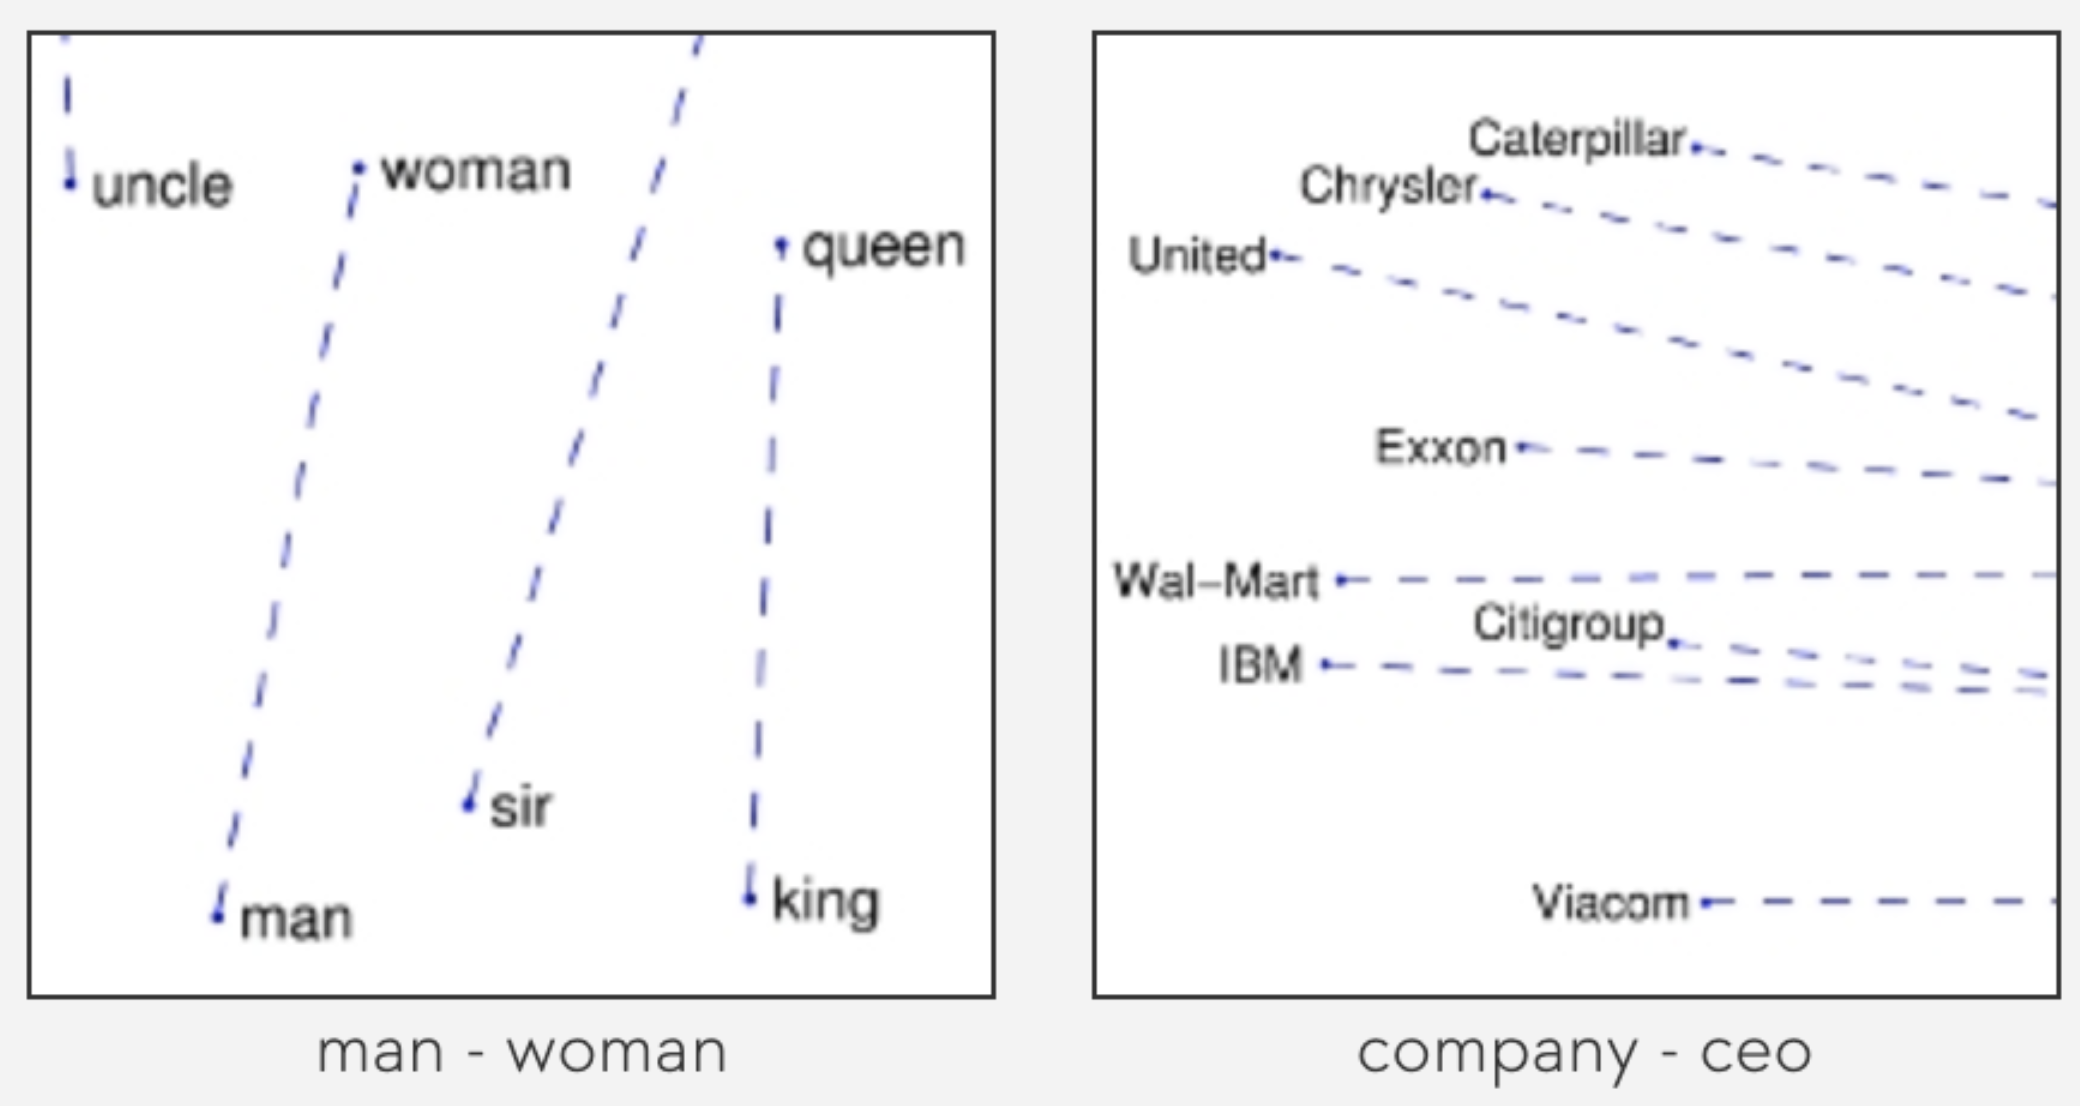

Figure 2: [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)

The 6B, 300 dimension version of the GloVe embeddings was used for this project. Some special tokens were added to the vocabulary for defining beginning (`<bos>`) and end of sentences (`<eos>`), as well as out-of-vocabulary words (`<unk>`) or padding (`<pad>`) tokens. 



```python
# We will first convert the embeddings into a numpy array
# to facilitate the next following operations
embs_npa = np.array(embeddings)
vocab_npa = np.array(vocab)

# Then, we create four new rows to accomodate our special tokens
# <bos>,<eos>: to denote the beginning and ending of sentences
# <unk>: to handle out-of-vocabulary words
# <pad>: to pad the batched embeddings
#
# The sentence boundaries are handled with random tensors, while the
# unknown vector is a mean of all existing vectors in the vocabulary.
# As for the padding, it is a zero vector, and is not expected to be
# affected by the gradient in any way.
bos_emb_npa = np.random.randn(1, embs_npa.shape[1])
eos_emb_npa = np.random.randn(1, embs_npa.shape[1])
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)    #embedding for '<unk>' token.
pad_emb_npa = np.zeros((1, embs_npa.shape[1]))

# The special labels are added at the end of the vocabulary.
# Then we convert the array into pytorch and save it as a pt file for the parameter file
# to load later
embs_npa = np.vstack((embs_npa, bos_emb_npa, eos_emb_npa, unk_emb_npa, pad_emb_npa))
embs_pt = torch.from_numpy(embs_npa).float()
torch.save(embs_pt, 'embeddings_weights.pt')
np.save('embeddings_vocab.npy', vocab_npa)
```

Some disadvantages come up as to the use of the representation for the UDC. For one, the use of the larger GloVe models is relatively demanding computationally; the largest vocabulary trained with a dimensionality of 300 represent about 660 million unique values in the embedding table, and can be intensive when the model is not frozen. 

In addition, the unique nature of the conversations found inside the UDC results in many out-of-vocabulary words resulting in a lack of representation for the bridge, with about 22% only being represented out of the box [(Jianxiong Dong, Jim Huang, _Enhance word representation for out-of-vocabulary on Ubuntu dialogue corpus_, 2018)](https://arxiv.org/pdf/1802.02614.pdf).

While there are some ways to improve on the search for words in vocabulary, we will look instead into using SentencePiece as our primary tokenization approach.


### **2.2.2 SentencePiece**

Created by Google, SentencePiece is an alternative tokenization algorithm which processes with a pre-determined vocabulary size. It's particularity is that of tokenizing subwords, which helps in categorizing out-of-vocabulary words that may not have been seen prior to training. The technique is commonly used amongst LLMs due to its reliability and efficiency.

One big difference to the vectorizer is that the SentencePiece creates subwords out of tokens, which helps in limiting the amount of unique tokens to document in the vocabulary, as well as covering words that would have otherwise not been seen during training. 



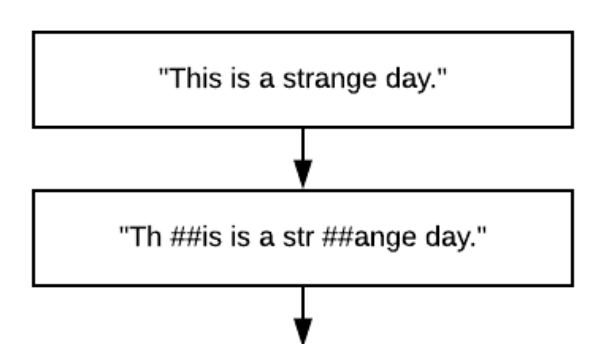

For this part of the project, Speechbrain was used to train the tokenizer. The tokenizer was also trained on the training dataset by reading the context part of each sample.

**You can run the code below** to run the tokenizer script and train the model.

In [ ]:
!rm -Rf /content/results/tokenizer
!python tokenizer/train.py tokenizer/hparams.yaml --output_folder='results/tokenizer/context/'

Now that the tokenization is complete, we can now proceed to going through our model approaches

# **3 Experimental Setup**

## **3.1 LSTM-based Sequence-to-Sequence Learning**

Our first iteration will be a basic Encoder-Decoder model using LSTM cells to generate the response. It also will not be using the whole context, but only the last utterance of the context. 




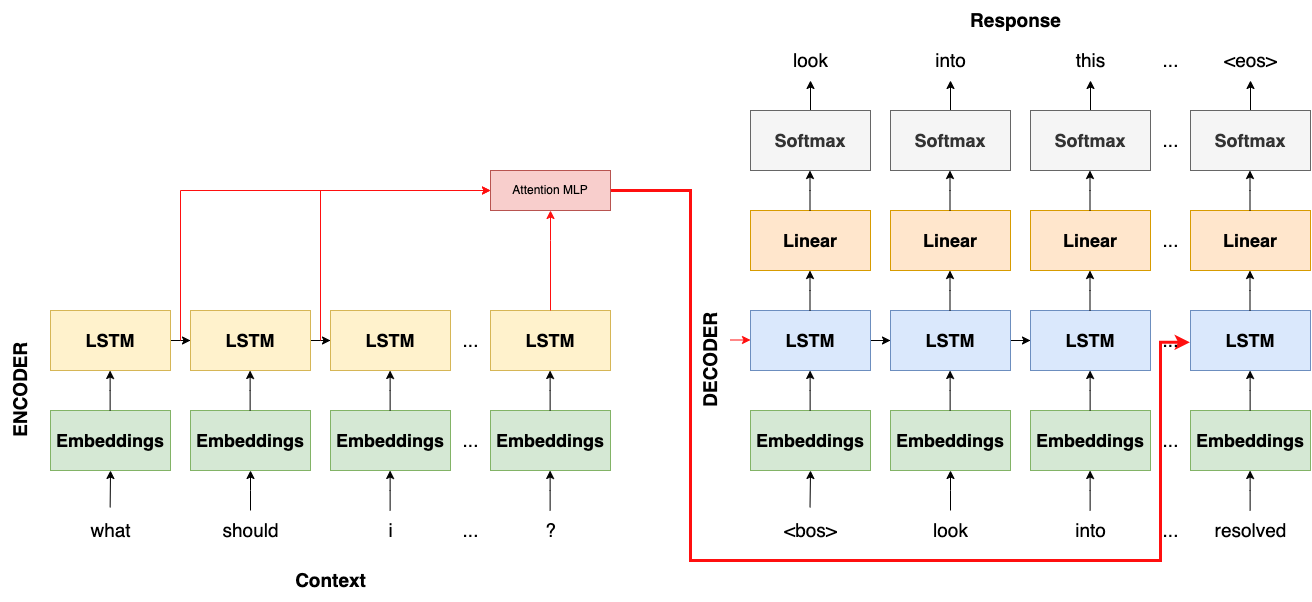

**Run the code below** to install Speechbrain. It will also install sacrebleu, a necessary Python package for tracking the BLEU metric.

In [50]:
%%capture
!pip install speechbrain
!pip install sacrebleu

**Run the code below** to start training. A GPU is required to run this part. it can take upwards of 2 hours to run the experiment. you can adjust the function by either using one of the smaller datasets (`train_small.csv`) or running a smaller amount of epochs.

In [ ]:
!rm -Rf /content/results/LSTM/1337
!python LSTM/train.py LSTM/hparams.yaml --device='cuda' --data_folder='.' --number_of_epochs=1 --batch_size=32

At this time the results are not that amazing, since it is just a baseline. We hope this will improve as we explore the next approaches.


## **3.2 Hierarchical RNN Encoder-Decoder**

UDC's context can hold many sentences, and therefore many tokens as a result. Even with the presence of attention and the use of the LSTM cells, the long sequences fed into a single RNN can lead to a loss of long-term dependencies of the earlier representations, thereby making the model be heavily reliant on the later parts of a given context. To circumvent this, we will instead employ the use of multiple RNNs in order to catch different levels of representations inside the context. 

The Hierarchical RNN Encoder-Decoder (HRED) makes use of two differently trained RNN encoder to catch a context's representation. The context will first be split into separate sentences based on the utterances found in a given sample; these will then be encoded by the first utterance level RNN Encoder using the tokens of each utterance. 

For each of the encoded states, the last layer will be fed into a context-level encoder. Essentially, the representation it learns will look at the entirety of the context, as opposed to the first encoder looking at the utterances individually. Using the last layers allows the encoder to read from the historical data from the prior RNN; during backpropagation, the fact the levels are separated allows both RNNs to learn from those separate long-term dependencies.




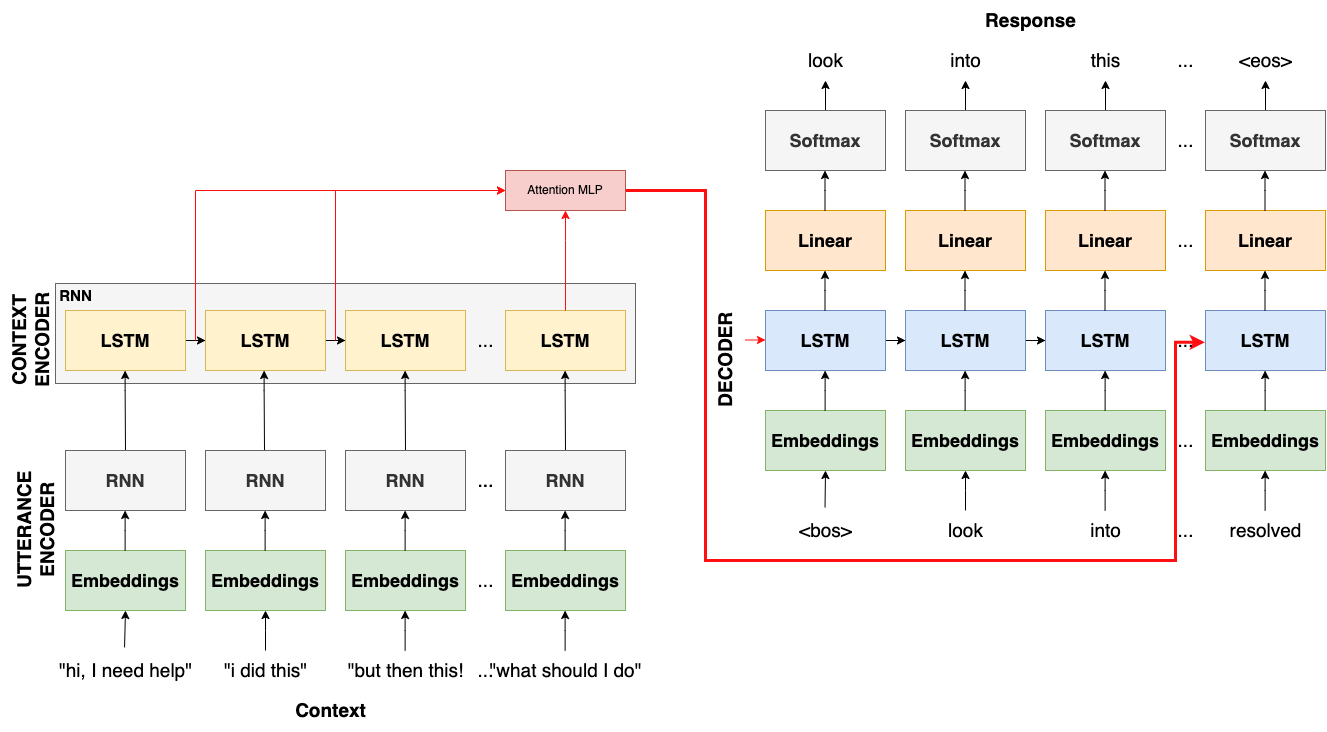

Another upgrade we will be making above the previous model is the use of a **beamsearcher**. Rather than taking the top result everytime, we will look into picking up the most consistent result at everytime, thereby allowing us to get the most plausible result at generation time

**Run the code below** to execute the training on the dataset using the HRED method. Once again, this can be a lengthy process (~1-2 hours), so you can run it using the smaller dataset and less epochs for debugging purposes.

In [ ]:
!rm -Rf /content/results/HRED/1337
!python HRED/train.py HRED/hparams.yaml --device='cuda' --data_folder='.' --number_of_epochs=5 --batch_size=32

Theoretically the HRED should show some marginal improvements from the baseline. The beamsearch would also help in finding the best responses out of the selections.

## **3.3 Pre-trained Transformer (GPT-2)**

Our final approach will be to make use of a pre-trained Large Language Model (LLM). These models have been pre-trained on large amounts of data, and come with good prior knowledge of the language they have been trained on. Those can readily be fetched through [HuggingFace](https://huggingface.co/models), a repository for open-source pre-trained models. For our project, we will make use of OpenAI's Generative Pre-trained Transformer (GPT-2) model.

While a Pre-trained model can be used out of the box, it can be beneficial to fine-tune it to the task's need using our own data, in order for the model to gain knowledge and hone its ability to perform was it is tasked to do at a stronger performance. Some steps need to be followed to achieve this:
1. Tokenize the text such that the transformer can understand it
2. Feed the input into the model to receive the logits generated.
3. Run a softmax and the loss function to optimize the model.

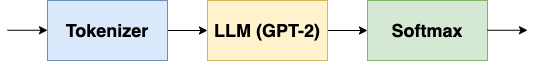

For our tokenization step, we will now use the `GPT2Tokenizer` to convert our text into an input that GPT-2 can understand. 

Because GPT-2 also only accepts an input, and no label, the context we provide to the model will have to change. rather than providing a separate `context` and `response` label, we will concatenate the sequences using special tokens represented in the model, such that the input looks as such:

```
<|context|> {context sequence} <|response|> {response sequence} <|endoftext|>
```

We will once again make use of a beamsearcher to find the best response for our given context. 

**Run the code below** to install the HuggingFace transformers package.

In [ ]:
!pip install transformers

To properly infer the Pretrained model from the hyperparameters file, we will create a separate file that will hold the HuggingFace model, thereby allowing us to call it from the YAML file, and add additional parameters to tweak its behavior (such as freezing the model, for example)

**Run the code below** for the training of the GPT2 model. Once again, this can be lengthy, and can require multiple hours to complete. Feel free to run it on a couple epochs to see how the results may look.

In [ ]:
!rm -Rf /content/results/GPT2/1337
!python GPT2/train.py GPT2/hparams.yaml --device='cuda' --data_folder='.' --number_of_epochs=1 --batch_size=4

# **4 Experimental Results**

The results obtained from the approaches are the following

| **Approach** | **Test Loss** | **Word Error Rate** | **Embedding Avg. Score** | **Vector Extrema Score** | **BLEU** |
|--------------|---------------|---------------------|--------------------------|--------------------------|----------|
| **_LSTM_**   | 4.31          | 87.59               | 0.521                      | 0.91                   | 18.79    |
| **HRED**     | 4.32          | 97.12               | 0.132                      | 0.693                  | 0.0      |
| **GPT-2**    | 7.10          | 123                 | 0.836                      | 0.829                  | 0.0014   |



# **5 Conclusion**


A lot more can be done to improve the performance of these generative results: From the start, GPT-3/GPT-4 already provide a much more impressive product out of the box compared to their predecessor. Other Transformer-based models such as BERT and T5 can also come up on the ring to show their prowess in Text Generation.

The largest bottleneck was in performing the training loop on the Colab instance. Despite using the Colab Pro membership with 16 GB of GPU memory, the training loop would often fail before hitting an epoch's checkpoint, thereby adding a lot of overhead into the tuning aspect of the experimentations. Adjusting the batch sizes and limiting the amount of training data used to come to a conclusion would help greatly, but it would come at the cost of less desirable results or an long training times due to the processing of multiple batch sizes. A potential approach to explore in the future would be to **backpropagate only after a certain amount of mini-batches have been processed**.  

The GPT-2 instance was most impressive in its handling of the English language, and despite the much smaller amount of samples provided, its Embedding Average Score was much stronger than its RNN counterparts. However, the memory it requires to train was tremendously large, and its usage could prove inefficient to finetune for smaller downstream tasks that can be well completed by LSTMs.

Outside of making use of large pre-trained model, spending time on preprocessing the data, and having more rigorous data cleaning could potentially yield better results. It can also help to perhaps make use of separate tokenizers trained on different sets of the data (the `context` and the `response` separately).

Finally, by looking at the UDC corpus created before the advent of the LLM, this shows how datasets still hold a potential that can be tapped with advancements of NLP.

**And that is all**! I hope you've enjoyed the exploration of these models in this project. 

# Citations